In [6]:

#TODO : REFACTOR
import numpy as np
np.random.seed(42)
import sklearn
import os
#import helper
import keras
import pickle
import math
import collections
import statistics
import random
import csv

from scipy import misc
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.colors
from skimage import data, img_as_float, exposure, io
from skimage import transform as transf
from tqdm import tqdm
from IPython.display import HTML
import cv2
import seaborn as sns


from keras.layers.advanced_activations import LeakyReLU 
from keras import backend as K
from keras.callbacks import CSVLogger, LearningRateScheduler,Callback,ModelCheckpoint,EarlyStopping,TensorBoard,ReduceLROnPlateau
from keras.layers.core import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import np_utils

from tensorflow.contrib.layers import flatten
from imp import reload


import loader
import preprocess
import plotter
import Models
import class_helper
import params




%matplotlib inline

#SEED = 22



# Load and Explore Data

In [117]:
#load data

X_train_orig, y_train_orig, X_test_orig, y_test_orig,X_val_orig,y_val_orig = loader.load_split_input_data()
print("data loaded")


Shapes:
X_train: (39209, 32, 32, 3)
X_test: (12630, 32, 32, 3)
X_valid: (4410, 32, 32, 3)
data loaded


## Basic Stats on data
* Number of training examples = 39209
* Number of validation examples = 4410
* Number of testing examples = 12630
* Image data shape = (32, 32, 3)
* Number of classes = 43

In [118]:
#Print basic stats, number of Train, Test, Valid samples


# Number of training examples
n_train = len(X_train_orig)

# Number of validation examples.
n_validation = len(X_val_orig)

# Number of testing examples.
n_test = len(X_test_orig)

# The shape of a traffic sign image
image_shape = X_train_orig[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.bincount(y_train_orig))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)



Number of training examples = 39209
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [119]:
class_stats = loader.get_class_stats(y_train_orig,y_test_orig,y_val_orig)

In [120]:
#utility class functions
def plot_first_images(first_images):
    
    nr = 10 ; nc = 10
    plt.figure(figsize=(nr,nc))
    for image,i in zip(first_images, range(len(first_images))):
        label = (str(i) + "\n"                                            # class
              + '('+str(class_stats['NumTrain'][i])+')')                              # no. of training samples
              
        plotter.plot_image(image.squeeze(), nr, nc, i+1, label)
    



## Training images, one from each class


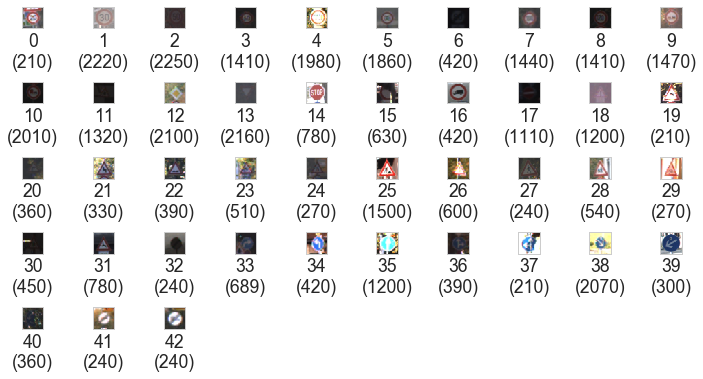

In [121]:
first_imgs = class_helper.get_first_images(X_train_orig,y_train_orig)
plot_first_images(first_imgs)

## Sign Names, counts and percentages of samples per class for Test, Train, Validate datasets

In [122]:
#sign_names=sign_names.round(2)

cm = sns.light_palette("purple", as_cmap=True)
#s = sign_names.style.format({'PerTrain': '{}%', 'PerTrain':'{}%'})
#highlight_max = Styler.highlight_max(subset=None, color='yellow', axis=0)
#format_percent = 
#s = sign_names.style.background_gradient(cmap=cm)

s = class_stats.round(2).copy()
s.columns = ['ClassID','Sign','#Train', '#Test', '#Valid', '%Train','%Test','%Valid']
html = (
    s.style
    .format("{}%", subset=['%Train','%Test','%Valid'])
    #.highlight_max(subset=['NumTrain'])
    .background_gradient(cmap=cm,subset=['#Train','#Test','#Valid','%Train','%Test','%Valid'])
    .render()
)

display(HTML(html))

,ClassID,Sign,#Train,#Test,#Valid,%Train,%Test,%Valid
0,0,Speed limit (20km/h),210,60,30,0.54%,0.48%,0.68%
1,1,Speed limit (30km/h),2220,720,240,5.66%,5.7%,5.44%
2,2,Speed limit (50km/h),2250,750,240,5.74%,5.94%,5.44%
3,3,Speed limit (60km/h),1410,450,150,3.6%,3.56%,3.4%
4,4,Speed limit (70km/h),1980,660,210,5.05%,5.23%,4.76%
5,5,Speed limit (80km/h),1860,630,210,4.74%,4.99%,4.76%
6,6,End of speed limit (80km/h),420,150,60,1.07%,1.19%,1.36%
7,7,Speed limit (100km/h),1440,450,150,3.67%,3.56%,3.4%
8,8,Speed limit (120km/h),1410,450,150,3.6%,3.56%,3.4%
9,9,No passing,1470,480,150,3.75%,3.8%,3.4%


## Visualization 

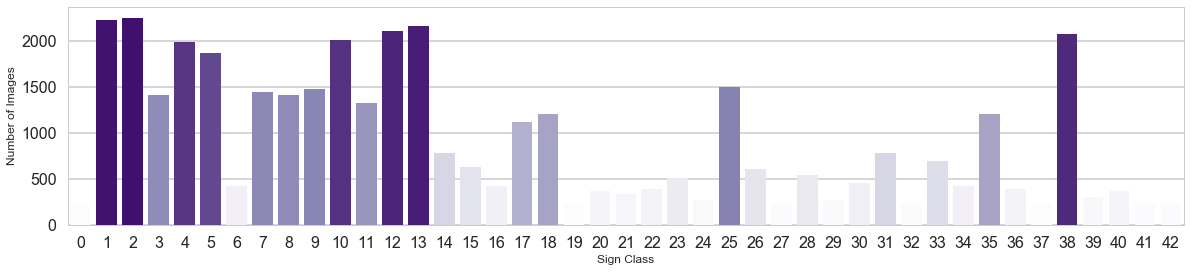

In [123]:
#print(class_stats.head())
plt.figure(figsize=(20,4))
#sns.color_palette("Blues")
#palette=sns.color_palette("Set2", 10)
#palette = sns.color_palette("coolwarm", 7)
norm = plt.Normalize(class_stats['NumTrain'].values.min(), class_stats['NumTrain'].values.max())
palette = plt.cm.Purples(norm(class_stats['NumTrain'])) 
#palette=sns.hls_palette(8, l=.3, s=.8)
sns.barplot(class_stats['ClassId'].values, class_stats['NumTrain'].values,palette=palette)
plt.xlabel('Sign Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.show()

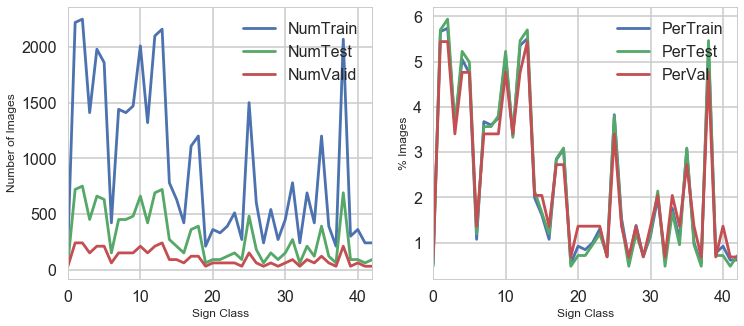

In [124]:



fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)


class_stats.loc[:, 'NumTrain':'NumValid'].plot(ax=ax0)
class_stats.loc[:, 'PerTrain':'PerVal'].plot(ax=ax1)

ax0.set_xlabel('Sign Class', fontsize=12)
ax0.set_ylabel('Number of Images', fontsize=12)

ax1.set_xlabel('Sign Class', fontsize=12)
ax1.set_ylabel('% Images', fontsize=12)



#print(class_stats)


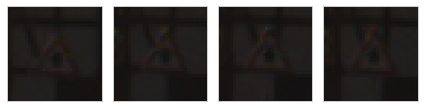

In [125]:

class_11_images = class_helper.get_images_for_class(11,X_train_orig, y_train_orig)
for i in range(4):
    plotter.plot_image(class_11_images[i], 1, 4, i+1)

In [126]:
mean = np.mean(X_train_orig)
std = np.std(X_train_orig)
dark, bright, dark_mean, bright_mean = plotter.get_dark_bright_imgs(class_11_images[:100],mean,std)
print('Number of dark images: '+str(len(dark)))
print('Number of bright images: '+str(len(bright)))


Number of dark images: 52
Number of bright images: 48


There are 52 images in the  dataset


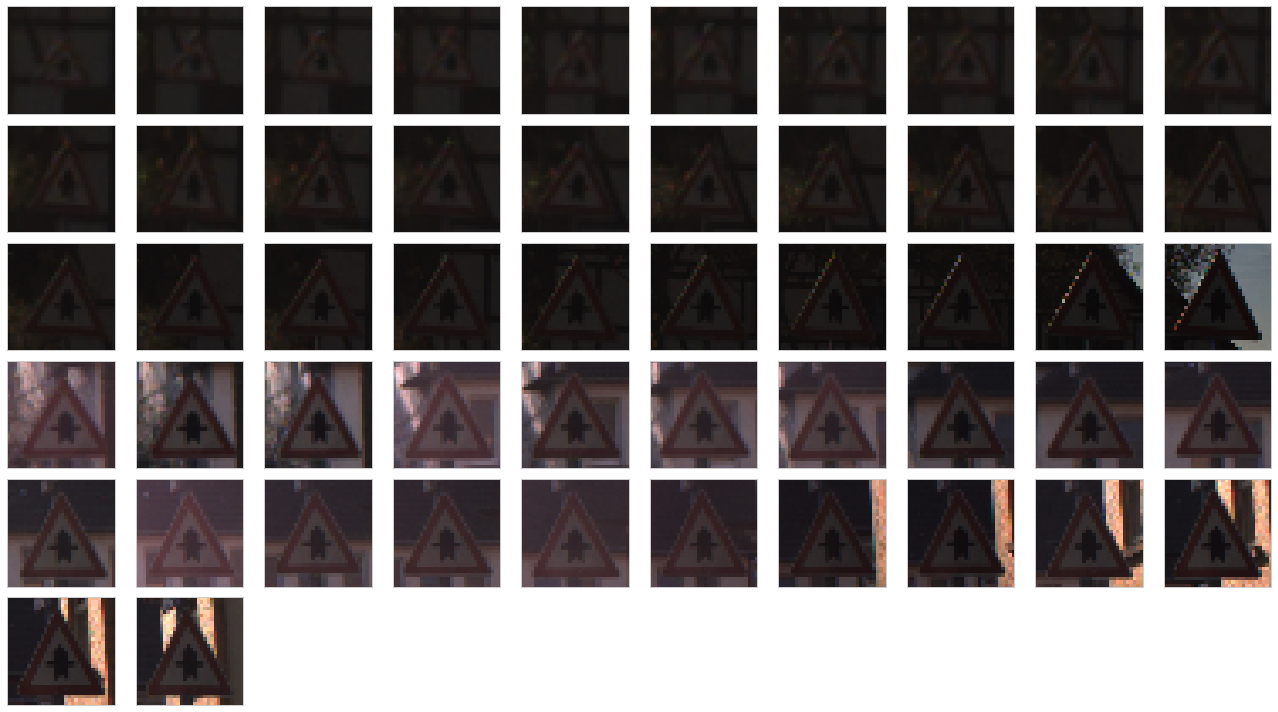

In [ ]:

plotter.plot_images(-1,dark,10,"")

In [ ]:
plotter.plot_images(-1,bright,10,"")

There are 48 images in the  dataset


In [ ]:
plotter.plot_2_datasets(np.asarray(dark[0:4]), preprocess.conv_to_grayscale_data(np.asarray(dark[0:4])),'Original', 'Grayscale')

In [ ]:
plotter.plot_2_datasets(np.asarray(bright[16:20]), preprocess.conv_to_grayscale_data(np.asarray(bright[16:20])),'Original','Grayscale')


In [ ]:
img_dark = dark[0]
img_bright = bright[8]
img_dark_gry = preprocess.conv_to_grayscale_img(img_dark)
img_bright_gry = preprocess.conv_to_grayscale_img(img_bright)

In [ ]:
#utility function to help  visualize
def plot_equalize_color_gray(img_dark_equal, img_dark_equal_gry, img_bright_equal, img_bright_equal_gry,op):
    plotter.plot_image(img_dark, 2,4,1, "Original Dark")
    plotter.plot_image(img_dark_equal, 2,4,2,op+" Dark")
    plotter.plot_image(img_dark_gry, 2,4,3, "Original Dark Grey")

    plotter.plot_image(img_dark_equal_gry,2,4,4, op+" Dark Grey")
    plotter.plot_image(img_bright, 2,4,5, "Original Bright")
    plotter.plot_image(img_bright_equal,2,4,6, op+" Bright")
    plotter.plot_image(img_bright_gry, 2,4,7, "Original Bright Grey")

    plotter.plot_image(img_bright_equal_gry,2,4,8, op+" Bright Grey")




In [ ]:
img_dark_contrast = preprocess.contrast_stretch_img(img_dark)
img_bright_contrast = preprocess.contrast_stretch_img(img_bright)
img_dark_contrast_gry = preprocess.contrast_stretch_img(img_dark_gry)
img_bright_contrast_gry = preprocess.contrast_stretch_img(img_bright_gry)


plot_equalize_color_gray(img_dark_contrast,img_dark_contrast_gry,img_bright_contrast,img_bright_contrast_gry,"Contrast")

In [ ]:
img_dark_hist = preprocess.hist_equalize_img(img_dark)
img_bright_hist = preprocess.hist_equalize_img(img_bright)
img_dark_hist_gry = preprocess.hist_equalize_img(img_dark_gry)
img_bright_hist_gry = preprocess.hist_equalize_img(img_bright_gry)
plot_equalize_color_gray(img_dark_hist,img_dark_hist_gry,img_bright_hist,img_bright_hist_gry,"Hist-EQ")

In [ ]:
img_dark_adapteq = preprocess.adaptive_equalize_img(img_dark)
img_bright_adapteq = preprocess.adaptive_equalize_img(img_bright)
img_dark_adapteq_gry = preprocess.adaptive_equalize_img(img_dark_gry)
img_bright_adapteq_gry = preprocess.adaptive_equalize_img(img_bright_gry)
plot_equalize_color_gray(img_dark_adapteq,img_dark_adapteq_gry,img_bright_adapteq,img_bright_adapteq_gry,"Adapt-EQ")

In [ ]:
#referenced from 

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [ ]:
#### Everything below here is just to create the plot/graphs ####
# Display results
def hist_compare(img, img_contrast, img_hist, img_adapteq):
    fig = plt.figure(figsize=(10, 7)) 
    axes = np.zeros((2, 4), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)

    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])

    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')

    ax_hist.set_yticks(np.linspace(0, y_max, 5))
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_contrast, axes[:, 1])
    ax_img.set_title('Contrast stretching')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_hist, axes[:, 2])
    ax_img.set_title('Histogram equalization')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
    ax_img.set_title('Adaptive equalization')
    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

In [ ]:
hist_compare(img_dark, img_dark_contrast, img_dark_hist, img_dark_adapteq)


In [ ]:
hist_compare(img_dark, img_dark_contrast_gry, img_dark_hist_gry, img_dark_adapteq_gry)


In [ ]:
hist_compare(img_bright, img_bright_contrast, img_bright_hist, img_bright_adapteq)


In [ ]:
hist_compare(img_bright_gry, img_bright_contrast_gry, img_bright_hist_gry, img_bright_adapteq_gry)


# Preprocess

In [ ]:
X_train,y_train,X_test,y_test,X_val,y_val= preprocess.preprocess_aug_combine_save(X_train_orig,y_train_orig,X_test_orig,y_test_orig,X_val_orig,y_val_orig)

#clear unused variables
del X_train_orig
del y_train_orig
del X_test_orig
del y_test_orig
del X_val_orig
del y_val_orig

In [13]:
loader = reload(loader)
preprocess = reload(preprocess)

X_train,y_train,X_test,y_test,X_val,y_val=loader.load_combine_preprocessed("hae")




Loading data ...
preprocessed/preprocessed_hset_aug_gray.p
X_aug_all:  8600
y_aug_all:  8600
Data and modules loaded.
preprocessed/preprocessed_hist_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
Data and modules loaded.
preprocessed/preprocessed_hae_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
Data and modules loaded.
preprocessed/preprocessed_hcs_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
Data and modules loaded.
combining dataset 0 of type <class 'numpy.ndarray'> and length 8600
combining dataset 1 of type <class 'numpy.ndarray'> and length 34799
combining dataset 2 of type <class 'numpy.ndarray'> and length 34799
combining dataset 3 of type <class 'numpy.ndarray'> and length 34799
length of combined set : 112997


In [14]:
#one hot  encoding of y series


y_train_e= np_utils.to_categorical(y_train,num_classes=params.n_classes)
y_val_e = np_utils.to_categorical(y_val,num_classes=params.n_classes)
y_test_e = np_utils.to_categorical(y_test,num_classes=params.n_classes)





In [39]:
def save_model_history(label,model_dir,history) :
    suffix='.log'
    
    filename = os.path.join(model_dir,'history_'+label+suffix)
    
    with open(filename, 'wb') as f:
        pickle.dump(history, f)
    print("History saved in file "+filename)
    

import tensorflow as tf
class LearningRateTracker(Callback):
    def __init__(self,model):
        
        self.model = model
        
    def on_epoch_end(self, epoch, logs={}):
        
        # _lr = K.get_value(tf.to_float(model.optimizer.lr, name='ToFloat'))
        # _decay = tf.to_float(model.optimizer.decay, name='ToFloat')
        #_iter = tf.to_float(model.optimizer.iterations, name='ToFloat')
        
        lr = K.get_value(self.model.optimizer.lr)
        
        print("\nCurrent learning rate: "+str(lr))

                    
def train_model_(model,label,flag_earlystop=True,flag_reduceLR=True, flag_lrsched=False,flag_tensorboard=True):
    
    batch_size=512
    epochs=20
    
    #cwd =os.getcwd()
    #print("CWD: "+str(cwd))
    #model_dir = os.path.join(cwd,params.model_dir,label)
    model_dir = os.path.join(params.model_dir,label)
    print(model_dir)
    if not os.path.exists(model_dir):
        try:
            print("create new dir")
            os.makedirs(model_dir)
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                print("error making directory")
                raise

    else:
        print("dir exists")
    
    # Compile and train the model
    suffix = '.hdf5'
    weights_file = os.path.join(model_dir,'weights_'+label+suffix)
    print("weights file: "+weights_file)
    
    adam = Adam()
    callbacks=[]
    if (flag_tensorboard==True):
        tensorboard=TensorBoard(log_dir=model_dir, histogram_freq=0, batch_size=batch_size, write_graph=True)
        callbacks.append(tensorboard)

    if (flag_earlystop == True):
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5 , verbose=2, mode='auto')
        callbacks.append(early_stop)
        
    if (flag_reduceLR == True):
        flag_lrsched=False
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.000001)
        callbacks.append(reduce_lr)

    #lr =  K.get_value(model.optimizer.lr)
    
    
    
    #lr = 0.0001
    if (flag_lrsched == True):
        lr = 0.001
       
        adam=Adam(lr=lr)
        def lr_schedule(epoch):
            #print("-----------------------------epoch : "+str(epoch))
            #print (lr*(0.1 ** int(epoch / 4)))
            return lr * ( 0.5 ** int(epoch / 5))

        lr_sched = LearningRateScheduler(lr_schedule)
        callbacks.append(lr_sched)
    
    model.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])
    print("starting LR:"+str(K.get_value(model.optimizer.lr)))
    trackLR = LearningRateTracker(model)
    
    csv_logger = CSVLogger(os.path.join(model_dir,'training.log'), append=True)
    checkpointer = ModelCheckpoint(filepath=weights_file, verbose=2, save_best_only=True, save_weights_only=True)
    callbacks.append(csv_logger)
    callbacks.append(checkpointer)
    callbacks.append(trackLR)
    
    print("CALLBACKS : "+str(callbacks))
    try:

        history = model.fit(X_train, y_train_e,
                    batch_size=batch_size, epochs=epochs,
                    #callbacks=[checkpointer,early_stop,lr_sched],
                    callbacks=callbacks,
                    #shuffle=False,
                    verbose=1, validation_data=(X_val, y_val_e))

    except KeyboardInterrupt:
        print("training interrupted")

    #print(history.history)
    evaluate = model.evaluate(X_test,y_test_e)
    print("---------------------------------------")
    print(evaluate)
    try:
        save_model_history(label,model_dir,history.history)
        
    except OSError as exc: 
        return  history.history, evaluate
    return history.history,evaluate

In [40]:
model3 = Models.deep_cnn_model(flag_BN=True,flag_STN=True)
history3,evaluate3= train_model_(model3,"BN_STN_reduceLR",flag_earlystop=False,flag_reduceLR=True, flag_lrsched=False,flag_tensorboard=True)


model/BN_STN_reduceLR
create new dir
weights file: model/BN_STN_reduceLR/weights_BN_STN_reduceLR.hdf5
starting LR:0.001
CALLBACKS : [<keras.callbacks.TensorBoard object at 0x7f555340c9b0>, <keras.callbacks.ReduceLROnPlateau object at 0x7f555340c828>, <keras.callbacks.CSVLogger object at 0x7f555342ce10>, <keras.callbacks.ModelCheckpoint object at 0x7f55533d3c88>, <__main__.LearningRateTracker object at 0x7f555342cef0>]
Train on 112997 samples, validate on 4410 samples
Epoch 1/20
112640/112997 [============================>.] - ETA: 0s - loss: 1.1153 - acc: 0.6997Epoch 00000: val_loss improved from inf to 1.62021, saving model to model/BN_STN_reduceLR/weights_BN_STN_reduceLR.hdf5

Current learning rate: 0.001
112997/112997 [==============================] - 76s - loss: 1.1125 - acc: 0.7004 - val_loss: 1.6202 - val_acc: 0.4839
Epoch 2/20
112640/112997 [============================>.] - ETA: 0s - loss: 0.1758 - acc: 0.9506Epoch 00001: val_loss improved from 1.62021 to 0.13469, saving model

In [38]:
model5 = Models.deep_cnn_model(flag_BN=True,flag_STN=True)
history5,evaluate5= train_model_(model5,"BN_STN_lrsched_2",flag_earlystop=False,flag_reduceLR=False, flag_lrsched=True,flag_tensorboard=True)


model/BN_STN_lrsched_2
create new dir
weights file: model/BN_STN_lrsched_2/weights_BN_STN_lrsched_2.hdf5
starting LR:0.001
CALLBACKS : [<keras.callbacks.TensorBoard object at 0x7f5558f8c390>, <keras.callbacks.LearningRateScheduler object at 0x7f5558f8c208>, <keras.callbacks.CSVLogger object at 0x7f5558f04b70>, <keras.callbacks.ModelCheckpoint object at 0x7f5558f2b7b8>, <__main__.LearningRateTracker object at 0x7f5558f04c88>]
Train on 112997 samples, validate on 4410 samples
Epoch 1/20
112640/112997 [============================>.] - ETA: 0s - loss: 1.1156 - acc: 0.6992Epoch 00000: val_loss improved from inf to 2.43752, saving model to model/BN_STN_lrsched_2/weights_BN_STN_lrsched_2.hdf5

Current learning rate: 0.001
112997/112997 [==============================] - 76s - loss: 1.1129 - acc: 0.6999 - val_loss: 2.4375 - val_acc: 0.1887
Epoch 2/20
112640/112997 [============================>.] - ETA: 0s - loss: 0.1723 - acc: 0.9523Epoch 00001: val_loss improved from 2.43752 to 0.25603, sav

In [26]:
label = "del"
suffix = '.log'
no_stn_his_f = os.path.join(params.model_dir,label,'history_'+label+suffix)
print(no_stn_his_f)

file = open(no_stn_his_f,'rb')
history2 = pickle.load(file)
file.close()
print(history2)


model/del/history_del.log
{'acc': [0.0, 0.10000000149011612, 0.0, 0.5, 0.60000002384185791, 0.70000004768371582, 0.60000002384185791, 0.89999997615814209, 1.0, 0.89999997615814209, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [4.5337343215942383, 3.8413276672363281, 3.1171016693115234, 1.8682079315185547, 1.531541109085083, 1.4082975387573242, 1.1535065174102783, 0.66910427808761597, 0.36537763476371765, 0.23902735114097595, 0.054328691214323044, 0.16448825597763062, 0.066185027360916138, 0.087317124009132385, 0.0345185287296772, 0.022558979690074921, 0.012508140876889229, 0.0031310231424868107, 0.051270700991153717, 0.015403624624013901], 'val_acc': [0.70000004768371582, 0.80000001192092896, 0.80000001192092896, 0.80000001192092896, 0.30000001192092896, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_loss': [3.6813387870788574, 3.6683633327484131, 3.6738817691802979, 3.6710295677185059, 3.6724271774291992, 3.6787319183349609, 3.6943674087

## Visualize Model output between Layers

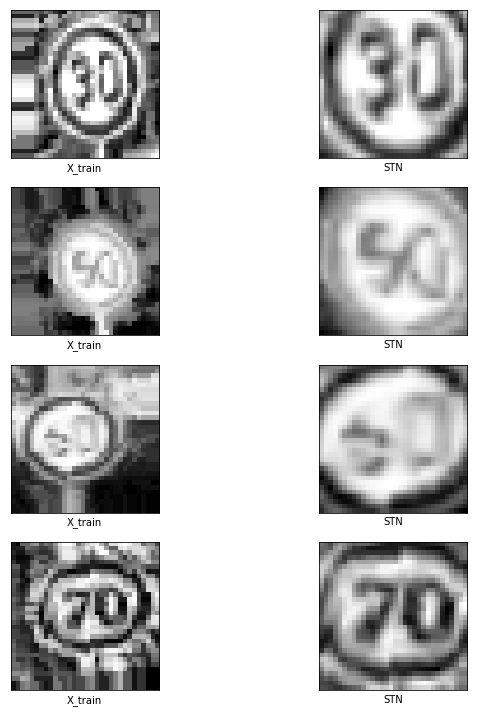

In [460]:
import keras.backend as K
x = model.input
y = model.layers[0].output
funct = K.function([x], [y])
first_imgs = class_helper.get_first_images(X_train,y_train)

Xresult = funct([first_imgs[1:5]])
plotter.plot_2_datasets(first_imgs[1:5],np.asarray(Xresult).squeeze(),"X_train","STN")

In [1]:
plotter = reload(plotter)

# Get the convolutional layers
conv2d_layers = [layer for layer in model.layers if isinstance(layer, Convolution2D)]
# select two images
img_indices = np.asarray([150,1000])
sel_imgs = X_train[img_indices]

# keras function 
conv_funct = K.function([model.layers[0].input, K.learning_phase()], [layer.output for layer in conv2d_layers])
imgs_layers_outputs = conv_funct([sel_imgs, 0])

for img_no in range(len(img_indices)):
    plt.title("Original Image")
    imshow(sel_imgs[img_no].squeeze(), cmap='gray')
    plt.tight_layout()
    plt.show()

    for conv_no, layer_outputs in enumerate(imgs_layers_outputs):
        layer_outputs_for_img = layer_outputs[img_no]
        print("Transformations in Convolution Layer %d" % conv_no)
        figures = [layer_outputs_for_img[:, :, output] for output in range(layer_outputs_for_img.shape[-1])]
        dims = plotter.get_dim(len(figures))
        plotter.plot_figures(figures, dims)




NameError: name 'reload' is not defined

In [9]:
model = Models.deep_cnn_model(flag_BN=True,flag_STN=False)
history,evaluate= train_model_(model,"BN_No_STN",flag_earlystop=False,flag_reduceLR=False, flag_lrsched=False,flag_tensorboard=True)


CWD: /home/carnd/KerasTrafficSignClassifier
/home/carnd/KerasTrafficSignClassifier/model/BN_No_STN
/home/carnd/KerasTrafficSignClassifier/model/BN_No_STN/weights_BN_No_STN.hdf5
starting LR:0.001
CALLBACKS : [<keras.callbacks.TensorBoard object at 0x7f1c52fc1ac8>, <keras.callbacks.CSVLogger object at 0x7f1c52fe5358>, <keras.callbacks.ModelCheckpoint object at 0x7f1c52fe5d30>, <__main__.LearningRateTracker object at 0x7f1c52fe5828>]
Train on 112997 samples, validate on 4410 samples
Epoch 1/20
112640/112997 [============================>.] - ETA: 0s - loss: 1.3172 - acc: 0.6293Epoch 00000: val_loss improved from inf to 3.42156, saving model to /home/carnd/KerasTrafficSignClassifier/model/BN_No_STN/weights_BN_No_STN.hdf5

Current learning rate: 0.001
112997/112997 [==============================] - 61s - loss: 1.3147 - acc: 0.6301 - val_loss: 3.4216 - val_acc: 0.1181
Epoch 2/20
112640/112997 [============================>.] - ETA: 0s - loss: 0.3432 - acc: 0.8931Epoch 00001: val_loss improv

NameError: name 'history2' is not defined

In [13]:
model2 = Models.deep_cnn_model(flag_BN=True,flag_STN=True)
history2,evaluate2= train_model_(model2,"BN_STN_001",flag_earlystop=False,flag_reduceLR=False, flag_lrsched=False,flag_tensorboard=True)


CWD: /home/carnd/KerasTrafficSignClassifier
/home/carnd/KerasTrafficSignClassifier/model/BN_STN_001
/home/carnd/KerasTrafficSignClassifier/model/BN_STN_001/weights_BN_STN_001.hdf5
starting LR:0.001
CALLBACKS : [<keras.callbacks.TensorBoard object at 0x7f1c2a7db198>, <keras.callbacks.CSVLogger object at 0x7f1c2a7fc048>, <keras.callbacks.ModelCheckpoint object at 0x7f1c2a7fc4e0>, <__main__.LearningRateTracker object at 0x7f1c2a7fc390>]
Train on 112997 samples, validate on 4410 samples
Epoch 1/20
112640/112997 [============================>.] - ETA: 0s - loss: 1.0738 - acc: 0.7060Epoch 00000: val_loss improved from inf to 2.18488, saving model to /home/carnd/KerasTrafficSignClassifier/model/BN_STN_001/weights_BN_STN_001.hdf5

Current learning rate: 0.001
112997/112997 [==============================] - 77s - loss: 1.0711 - acc: 0.7067 - val_loss: 2.1849 - val_acc: 0.2095
Epoch 2/20
112640/112997 [============================>.] - ETA: 0s - loss: 0.1725 - acc: 0.9513Epoch 00001: val_loss i

In [20]:
print(evaluate)

NameError: name 'evaluate' is not defined

In [30]:
model4 = Models.deep_cnn_model(flag_BN=True,flag_STN=True)
history4,evaluate4= train_model_(model4,"BN_STN_lrsched",flag_earlystop=False,flag_reduceLR=False, flag_lrsched=True,flag_tensorboard=True)


model/BN_STN_lrsched
create new dir
weights file: model/BN_STN_lrsched/weights_BN_STN_lrsched.hdf5
starting LR:0.001
CALLBACKS : [<keras.callbacks.TensorBoard object at 0x7f5584212fd0>, <keras.callbacks.LearningRateScheduler object at 0x7f5584212860>, <keras.callbacks.CSVLogger object at 0x7f55841c8cc0>, <keras.callbacks.ModelCheckpoint object at 0x7f55841db208>, <__main__.LearningRateTracker object at 0x7f55841c8908>]
Train on 112997 samples, validate on 4410 samples
Epoch 1/20
112640/112997 [============================>.] - ETA: 0s - loss: 1.0596 - acc: 0.7131Epoch 00000: val_loss improved from inf to 1.84895, saving model to model/BN_STN_lrsched/weights_BN_STN_lrsched.hdf5

Current learning rate: 0.001
112997/112997 [==============================] - 75s - loss: 1.0574 - acc: 0.7137 - val_loss: 1.8489 - val_acc: 0.3478
Epoch 2/20
112640/112997 [============================>.] - ETA: 0s - loss: 0.1651 - acc: 0.9541Epoch 00001: val_loss improved from 1.84895 to 0.09453, saving model 

## Training Accuracy, Loss Plots

model\BN_STN_001\history_BN_STN_001.log
model\BN_STN_001_reduceLR\history_BN_STN_001_reduceLR.log


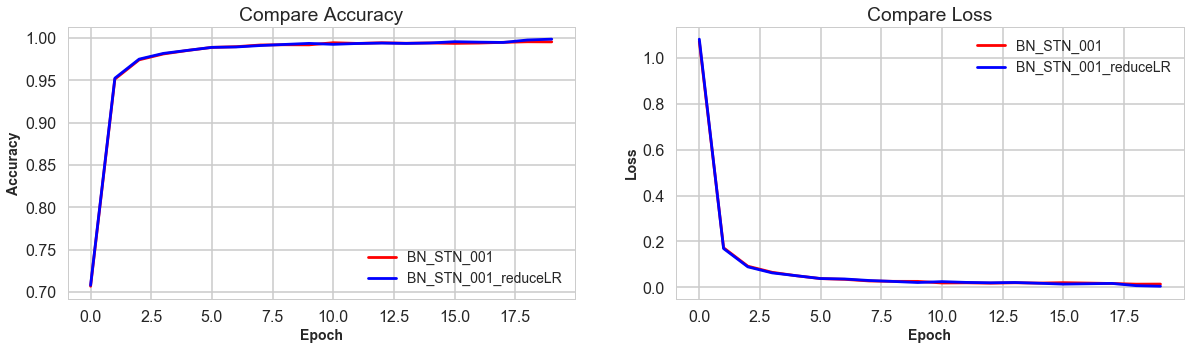

In [115]:
plotter=reload(plotter)
label = "BN_STN_001"
suffix = '.log'
no_stn_his_f = os.path.join(params.model_dir,label,'history_'+label+suffix)
print(no_stn_his_f)

file = open(no_stn_his_f,'rb')
history1 = pickle.load(file)
file.close()
#print(model_history)
#plotter.plot_train_loss_accuracy(model_history)


label = "BN_STN_001_reduceLR"
suffix = '.log'
no_stn_his_f = os.path.join(params.model_dir,label,'history_'+label+suffix)
print(no_stn_his_f)

file = open(no_stn_his_f,'rb')
history2 = pickle.load(file)
file.close()


compare_train_loss_accuracy(history1, history2, "BN_STN_001","BN_STN_001_reduceLR")

# Test and Evaluate

In [8]:

#load models
from keras.models import load_model
import Models 


#model_deep= load_model('deep_cnn_89_all_aug_on_hae.h5',custom_objects={'STN':SpatialTransformer})

print("loading model ")
label = "BN_STN_001_reduceLR"
weights_file = os.path.join(params.model_dir,label,"weights_"+label+".hdf5")
print(weights_file)
#weights_file="weights_deep_cnn_98.hdf5"
model = Models.deep_cnn_model(flag_BN=True,flag_STN=True)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


model.load_weights(weights_file)

print("Evaluating")
#load the best model 
#evaluate= model.evaluate(X_test,y_test_e,verbose=True)
#prob = model.predict(X_test)
#predictions = np.argmax(prob, axis=1)
#print(predictions)

loading model 
model\BN_STN_001_reduceLR\weights_BN_STN_001_reduceLR.hdf5
Evaluating


In [100]:
print(evaluate)


[0.056600172527838499, 0.98590657170198304]
(12630, 32, 32, 1)
[[  2.61761290e-11   8.33697430e-15   1.43859695e-18 ...,   1.02589924e-11
    1.11975854e-11   1.12836539e-13]
 [  8.43931587e-13   1.00000000e+00   9.50328005e-14 ...,   2.54187049e-21
    5.61371293e-22   4.53036151e-18]
 [  1.49067314e-10   1.48986878e-10   1.94238431e-10 ...,   8.80981746e-12
    9.48021043e-15   1.84177584e-13]
 ..., 
 [  8.44951046e-06   1.73337255e-02   1.86008754e-06 ...,   1.70716843e-11
    1.40377722e-06   8.97205994e-03]
 [  2.26910040e-19   3.38556422e-15   4.00442926e-16 ...,   9.99720562e-18
    1.75365647e-22   6.22118542e-16]
 [  2.33229410e-16   8.78993655e-13   5.82668679e-12 ...,   6.13495810e-10
    5.19625372e-14   1.11093614e-08]]
[16  1 38 ...,  5  7 10]


In [107]:
error_indices = np.where(predictions!=y_test)[0]
#print(error_indices)
numErrors = error_indices.shape[0]
print ("No of wrong predictions: ", numErrors)
error_classes = [y_test[i] for i in error_indices]
df_error_truth = pd.DataFrame.from_dict(collections.Counter(error_classes), orient='index')
#print(df_error_truth)

#print((df_errors).shape)
df_error_truth = df_error_truth.rename(columns={0:'Errors'})
#print(df_errors)

class_stats['Errors'] = df_error_truth['Errors']
class_stats.fillna(value=0, inplace=True)
class_stats['Error%'] = ((class_stats['Errors']/class_stats['NumTest'])*100).round(2)
class_stats['Error%Train'] = ((class_stats['Errors']/class_stats['NumTrain'])*100).round(2)


No of wrong predictions:  267


In [140]:
cm = sns.light_palette("purple", as_cmap=True)
#s = sign_names.style.format({'PerTrain': '{}%', 'PerTrain':'{}%'})
#highlight_max = Styler.highlight_max(subset=None, color='yellow', axis=0)
#format_percent = 
#s = sign_names.style.background_gradient(cmap=cm)

s = (class_stats[['ClassId','SignName','NumTrain','NumTest','NumValid','Errors','Error%','Error%Train']].
round(2).copy())
s.columns = ['ClassID','Sign','#Train', '#Test', '#Valid','Errors','%Error','%Error(Train)']
html = (
    s.style
    .format("{}%", subset=['%Error','%Error(Train)'])
    #.highlight_max(subset=['NumTrain'])
    .background_gradient(cmap=cm,subset=['#Train','#Test','#Valid','Errors','%Error','%Error(Train)'])
    .render()
)

display(HTML(html))
del html
del s


,ClassID,Sign,#Train,#Test,#Valid,Errors,%Error,%Error(Train)
0,0,Speed limit (20km/h),210,60,30,0,0.0%,0.0%
1,1,Speed limit (30km/h),2220,720,240,3,0.42%,0.14%
2,2,Speed limit (50km/h),2250,750,240,2,0.27%,0.09%
3,3,Speed limit (60km/h),1410,450,150,14,3.11%,0.99%
4,4,Speed limit (70km/h),1980,660,210,5,0.76%,0.25%
5,5,Speed limit (80km/h),1860,630,210,8,1.27%,0.43%
6,6,End of speed limit (80km/h),420,150,60,11,7.33%,2.62%
7,7,Speed limit (100km/h),1440,450,150,1,0.22%,0.07%
8,8,Speed limit (120km/h),1410,450,150,17,3.78%,1.21%
9,9,No passing,1470,480,150,0,0.0%,0.0%


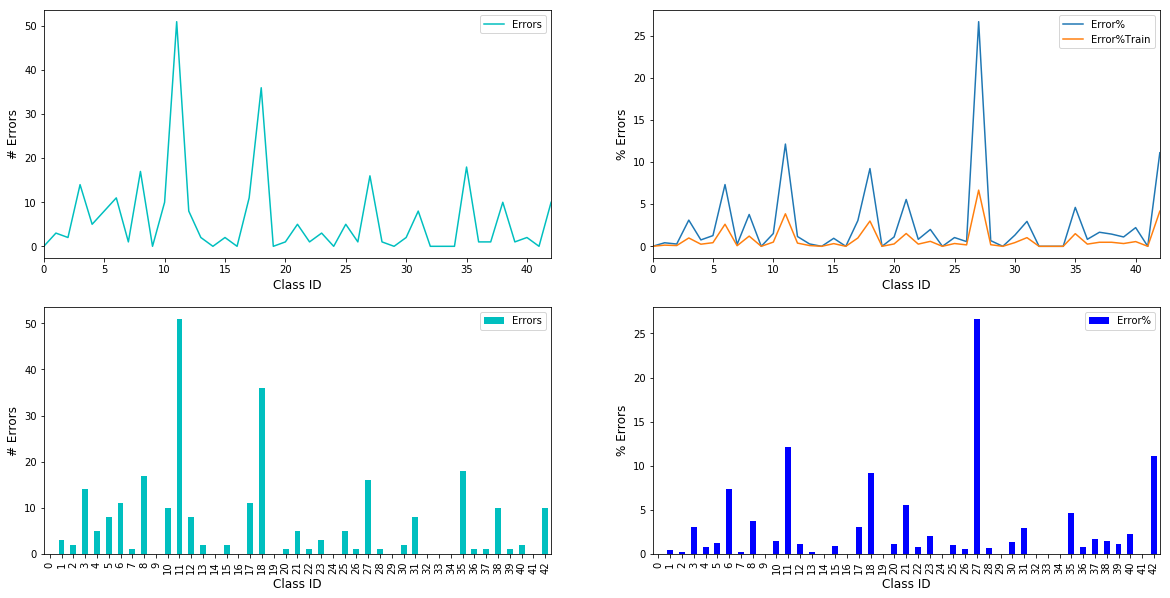

In [109]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(ncols=2,nrows=2,figsize=(20, 10), sharey=False)


class_stats[['Errors']].plot(ax=ax2,kind='bar',color = 'c')
class_stats[['Error%']].plot(ax=ax3,kind='bar',color = 'b')
class_stats[['Errors']].plot(ax=ax0,kind='line',color = 'c')
class_stats[['Error%','Error%Train']].plot(ax=ax1,kind='line')


ax0.set_xlabel('Class ID', fontsize=12)
ax0.set_ylabel('# Errors', fontsize=12)

ax1.set_xlabel('Class ID', fontsize=12)
ax1.set_ylabel('% Errors', fontsize=12)


ax2.set_xlabel('Class ID', fontsize=12)
ax2.set_ylabel('# Errors', fontsize=12)

ax3.set_xlabel('Class ID', fontsize=12)
ax3.set_ylabel('% Errors', fontsize=12)

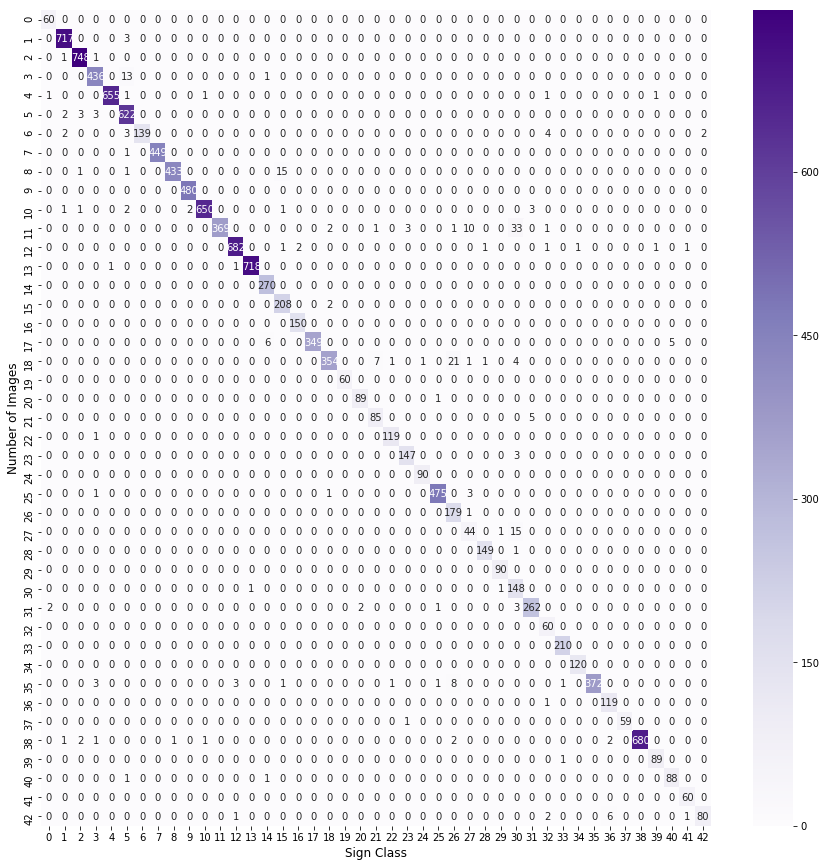

In [235]:

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches




palette = sns.color_palette('Purples')

cm = confusion_matrix(y_test, predictions)
#colormap = ListedColormap(palette.as_hex())

#cm = cm.pivot("Truth", "Predictions", "Errors")
ax = sns.heatmap(cm,annot=True, fmt="d", ax=ax,cmap="Purples")
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Truth', fontsize=12)
plt.show()

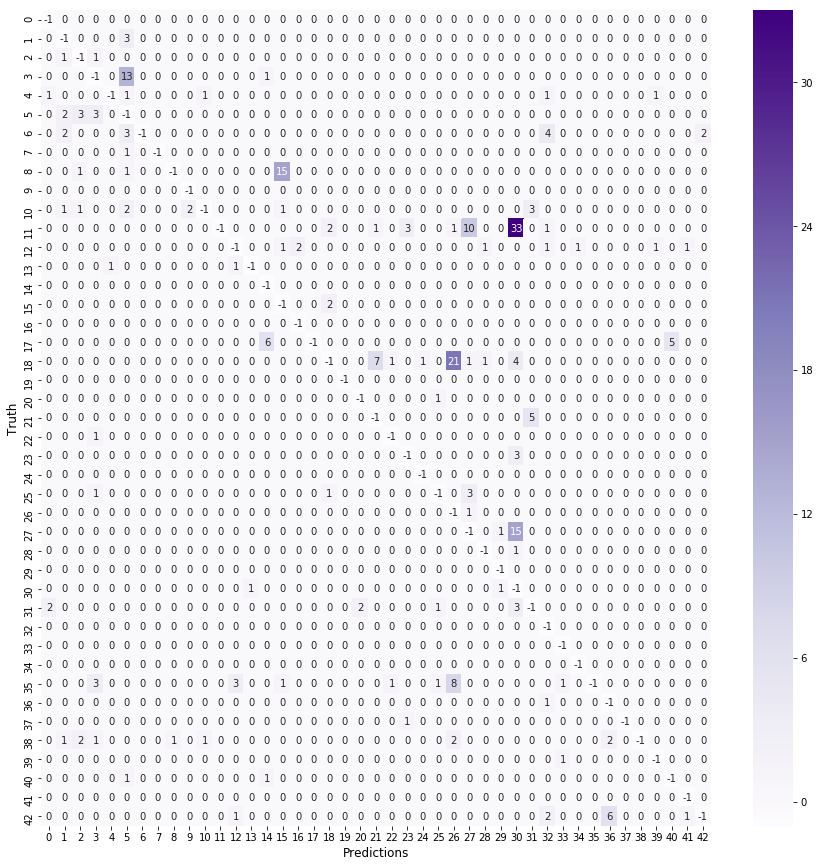

In [236]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches

palette = sns.color_palette('Purples')

cm = confusion_matrix(y_test, predictions)
#colormap = ListedColormap(palette.as_hex())


np.fill_diagonal(cm,-1)

ax = sns.heatmap(cm,annot=True, fmt="d", ax=ax,cmap="Purples")
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Truth', fontsize=12)
plt.show()

In [228]:
#df = sklearn.metrics.classification_report( labels=None, target_names=None, sample_weight=None, digits=2)
df1 = sklearn.metrics.precision_recall_fscore_support(y_test, predictions, labels=None, average=None,  sample_weight=None)
class_stats["F1"] = df1[2]
class_stats["Precision"] = df1[0]
#print(class_stats)

np.fill_diagonal(cm,0)


max_misclassified_class =  np.argmax(cm, axis=1)
#replace accurate classes with 'NA'
max_misclassified_class_errors =  np.amax(cm, axis=1)
print(max_misclassified_class_errors)
per=np.zeros(n_classes)
for i in range(n_classes):

    if (max_misclassified_class_errors[i] == 0):

        max_misclassified_class[i]= -1
        per[i]= np.nan
    else:
        per[i]=(max_misclassified_class_errors[i]/(class_stats.iloc[i]["NumTest"]-class_stats.iloc[i]["Errors"]))*100

class_stats["Max_Misclassified_as"]=max_misclassified_class
class_stats["Max_Misclassified_Class_%"] = per


[ 0  3  1 13  1  3  4  1 15  0  3 33  2  1  0  2  0  6 21  0  1  5  1  3  0
  3  1 15  1  0  1  3  0  0  0  8  1  1  2  1  1  0  6]


In [263]:



s = (class_stats[["SignName","F1","Precision","Max_Misclassified_as","Max_Misclassified_Class_%"]]
.round(2).copy())
s.columns = ['Sign','Accuracy(F1)', 'Precision', 'Max Misclassified as','%Max_Misclassified_Class']
html = (
    s.style
    .format("{}%", subset=['%Max_Misclassified_Class'])
    #.highlight_max(subset=['NumTrain'])
    .background_gradient(cmap="Purples",subset=['Accuracy(F1)','Precision','%Max_Misclassified_Class'])
    .render()
)

display(HTML(html))
del html
del s





C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


,Sign,Accuracy(F1),Precision,Max Misclassified as,%Max_Misclassified_Class
0,Speed limit (20km/h),0.98,0.95,-1,nan%
1,Speed limit (30km/h),0.99,0.99,5,0.42%
2,Speed limit (50km/h),0.99,0.99,1,0.13%
3,Speed limit (60km/h),0.97,0.98,5,2.98%
4,Speed limit (70km/h),1,1,0,0.15%
5,Speed limit (80km/h),0.97,0.96,2,0.48%
6,End of speed limit (80km/h),0.96,1,32,2.88%
7,Speed limit (100km/h),1,1,5,0.22%
8,Speed limit (120km/h),0.98,1,15,3.46%
9,No passing,1,1,-1,nan%


Pedestrians :


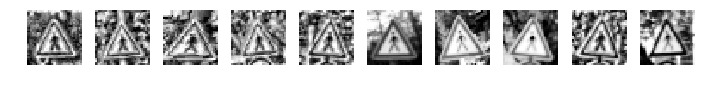

was misclassified as:
Beware of ice/snow :


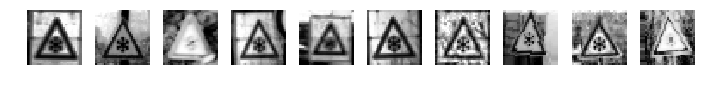

Right-of-way at the next intersection :


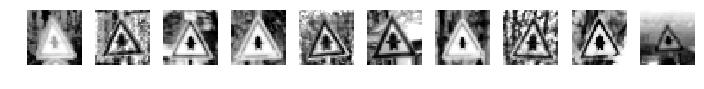

was misclassified as:
Beware of ice/snow :


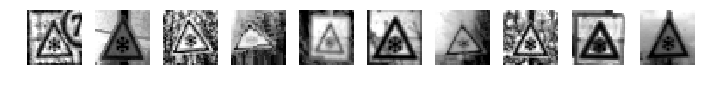

General caution :


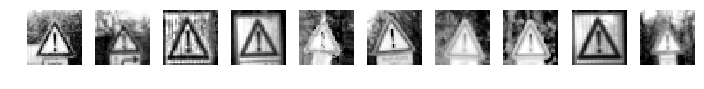

was misclassified as:
Traffic signals :


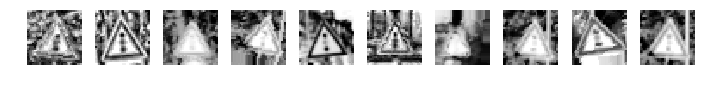

Double curve :


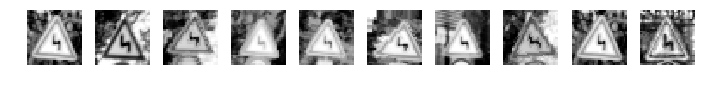

was misclassified as:
Wild animals crossing :


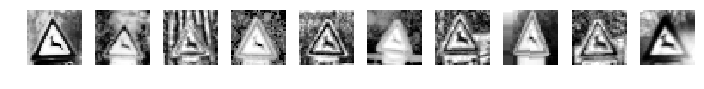

End of no passing by vechiles over 3.5 metric tons :


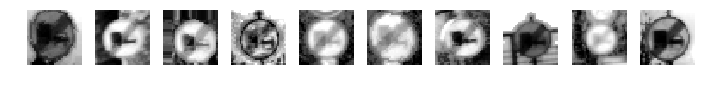

was misclassified as:
Go straight or right :


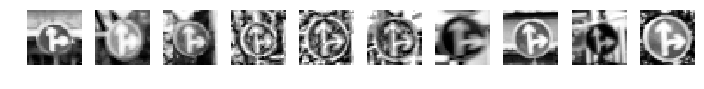

Children crossing :


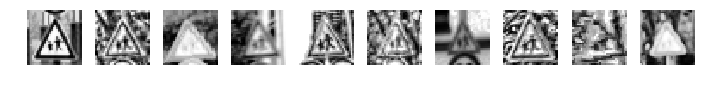

was misclassified as:
Pedestrians :


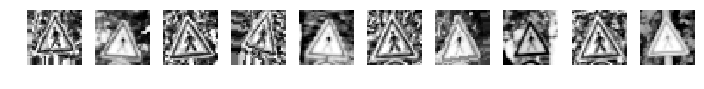

In [423]:

study_range = [27, 30, 11, 30, 18, 26, 21, 31, 42, 36,28,27]
compare = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0,1,0]
#study_range = [28,30,28,24,28,27]
#compare = [1,0,1,0,1,0]

implot = plt.figure(figsize=(12,4))
counter = 0
for classid in study_range:
    print (class_stats.SignName[classid],':')
    implot = plt.figure(figsize=(12,1))
    X_class = X_train[y_train==classid]
    #rnd_idx = np.random.random(range(len(X_class)), 10)
    rnd_idx=np.random.randint(0, high=len(X_class), size=10)

    for i in range(10):
        ax = implot.add_subplot(1,10,i + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(X_class[rnd_idx[i]].squeeze(),cmap='gray')
    plt.show()
    if compare[counter]:
        print ('was misclassified as:')
    counter += 1

In [68]:

### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg

# http://electronicimaging.spiedigitallibrary.org/data/journals/electim/927109/jei_22_4_041105_f010.png

#image1 = mpimg.imread('external-data/no-entry.png')

image1 = mpimg.imread('external-data/right-of-way.png')

#plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
#plotter.plot_image(image, 1, 3, 0)

#image2 = mpimg.imread('external-data/right-turn.png')

image2 = mpimg.imread('external-data/pedestrians_1.png')
#print('This image is:', type(image), 'with dimesions:', image.shape)
#plot_image(image, 1, 3, 0)
#actual.append([33, image])
#image3 = mpimg.imread('external-data/20kmph.png')

image3 = mpimg.imread('external-data/general_caution_1.png')
#plot_image(image, 1, 3, 0)
#actual.append([0, image])
#image4 = mpimg.imread('external-data/children-crossing.png')

image4 = mpimg.imread('external-data/children-crossing_1.png')
#plot_image(image, 1, 3, 0)
#actual.append([28, image])
#image5 = mpimg.imread('external-data/stop.png')

image5 = mpimg.imread('external-data/stop.png')
#plot_image(image, 1, 3, 0)
#actual.append([14, image])
#image6 = mpimg.imread('external-data/no-truck-passing.png')

image6 = mpimg.imread('external-data/no-truck-passing.png')
#plot_image(image, 1, 3, 0)
#actual.append([10, image])
X_test_new = [image1, image2, image3, image4, image5, image6]
y_test_new = [11,27,18,28,14,10]

In [69]:
from skimage import color, exposure, transform

def resize_data(data):
    print(np.asarray(data).shape)
    resize=[]
    # Histogram normalization in v channel
    for img in np.asarray(data):
        #print(img.shape)
        # central square crop
        
        # rescale to standard size
        img = transform.resize(img, (32, 32,3))
        import numpy, itertools


        #for i, j, k in itertools.product(*map(xrange, img.shape)):
        #img[k,i,j] = img [i,j,k]

        # roll color axis to axis 0
        #img = np.rollaxis(img, -1)
        resize.append(img)

    return np.asarray(resize)


#preprocess = reload(preprocess)
X_test_new_orig = np.copy(X_test_new)

#X_test_new = read_all_imgs()
X_test_new = resize_data(X_test_new)
print(X_test_new.shape)


X_test_new= preprocess.conv_to_grayscale_data(np.asarray(X_test_new))
#X_test_new = preprocess.hist_equalize(X_test_new)
X_test_new = preprocess.adaptive_equalize(X_test_new)
#X_test_new = preprocess.contrast_stretch(X_test_new)

(6,)


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(6, 32, 32, 3)


  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 6/6 [00:00<00:00, 54.90it/s]


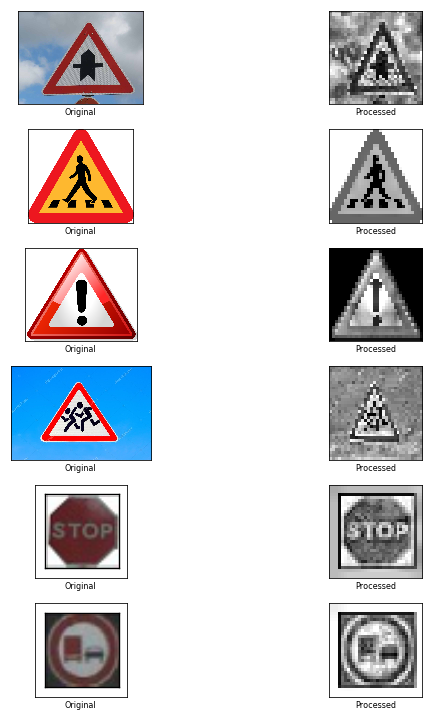

In [70]:
plotter = reload(plotter)
plotter.plot_2_datasets(X_test_new_orig.squeeze(),X_test_new.squeeze(),"Original", "Processed")


In [71]:
prob_new = model.predict(X_test_new)
preds_new = np.argmax(prob_new, axis=1)
print(y_test_new)
print(preds_new)

[11, 27, 18, 28, 14, 10]
[ 0  0 23  0  0  0]


In [72]:
plotter.plot_top_n_preds(X_test_new_orig,prob_new,np.asarray(class_stats.SignName),5)


NameError: name 'class_stats' is not defined

In [73]:

#study_range = [27, 30, 11, 30, 18, 26, 21, 31, 42, 36,28,27]
#compare = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0,1,0]
study_range = [28,30]
compare = [1,0]

implot = plt.figure(figsize=(12,4))
counter = 0
for classid in study_range:
    print (class_stats.SignName[classid],':')
    implot = plt.figure(figsize=(12,1))
    X_class = X_train[y_train==classid]
    #rnd_idx = np.random.random(range(len(X_class)), 10)
    rnd_idx=np.random.randint(0, high=len(X_class), size=10)

    for i in range(10):
        ax = implot.add_subplot(1,10,i + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(X_class[rnd_idx[i]].squeeze(),cmap='gray')
    plt.show()
    if compare[counter]:
        print ('was misclassified as:')
    counter += 1

NameError: name 'class_stats' is not defined

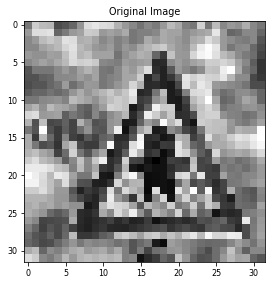

Transformations in Convolution Layer 0


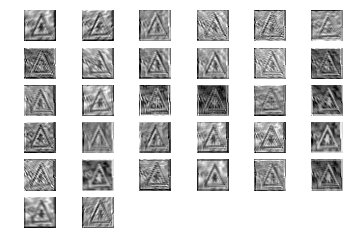

Transformations in Convolution Layer 1


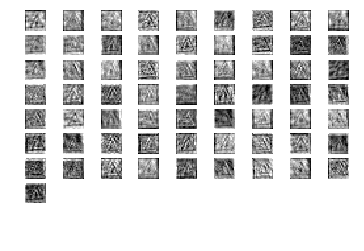

Transformations in Convolution Layer 2


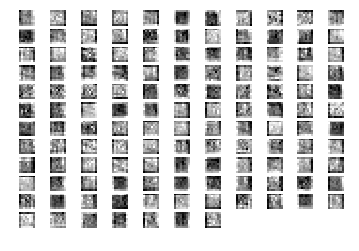

Transformations in Convolution Layer 3


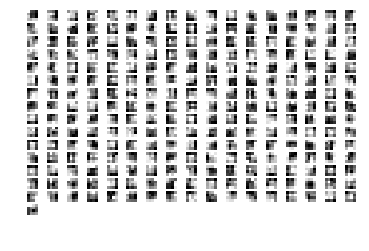

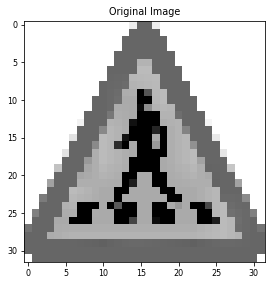

Transformations in Convolution Layer 0


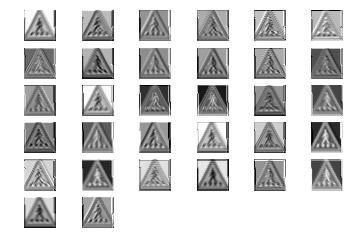

Transformations in Convolution Layer 1


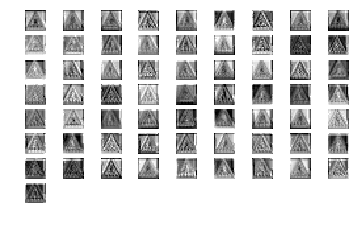

Transformations in Convolution Layer 2


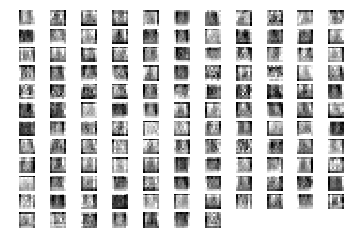

Transformations in Convolution Layer 3


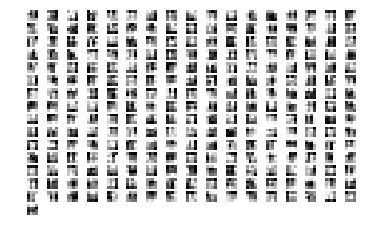